In [1]:
import colorthief as ct
import requests
from io import BytesIO
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [2]:
# Grab the data from the boardgame geek website
url = 'https://boardgamegeek.com/browse/boardgame'
response = requests.get(url)    

In [3]:
soup = BeautifulSoup(response.text, 'html.parser')

In [4]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('td')  if 'collection_thumbnail' in x['class']]

In [5]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [6]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

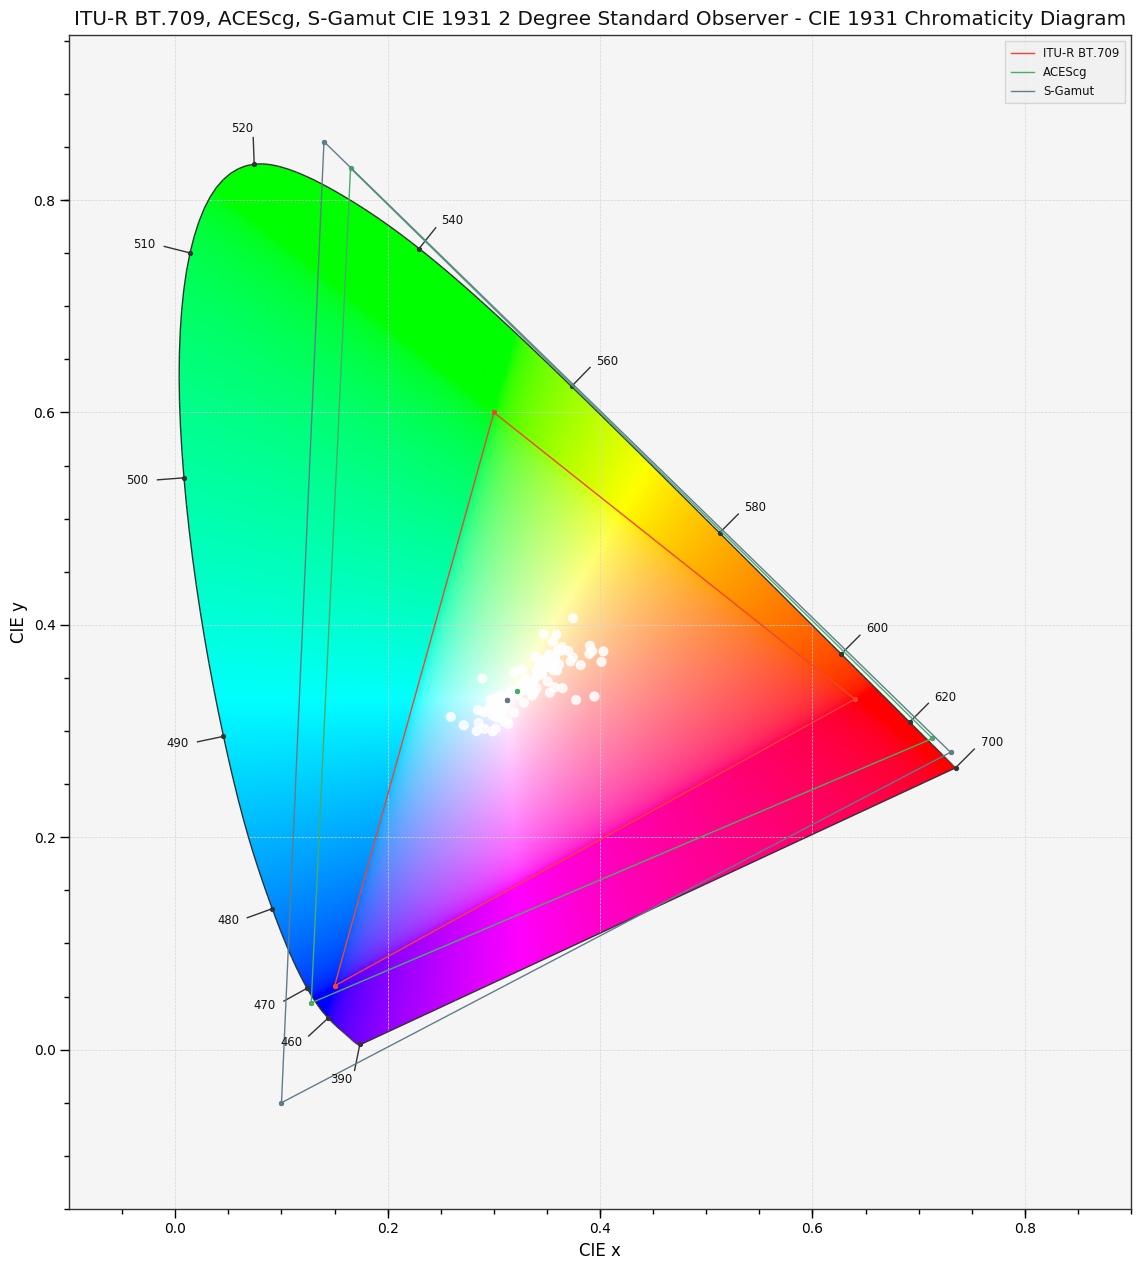

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bb83803ba8>)

In [10]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGB, 'ITU-R BT.709', colourspaces=['ACEScg', 'S-Gamut', 'Pointer Gamut'])

In [8]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6) for x in colour_thief]

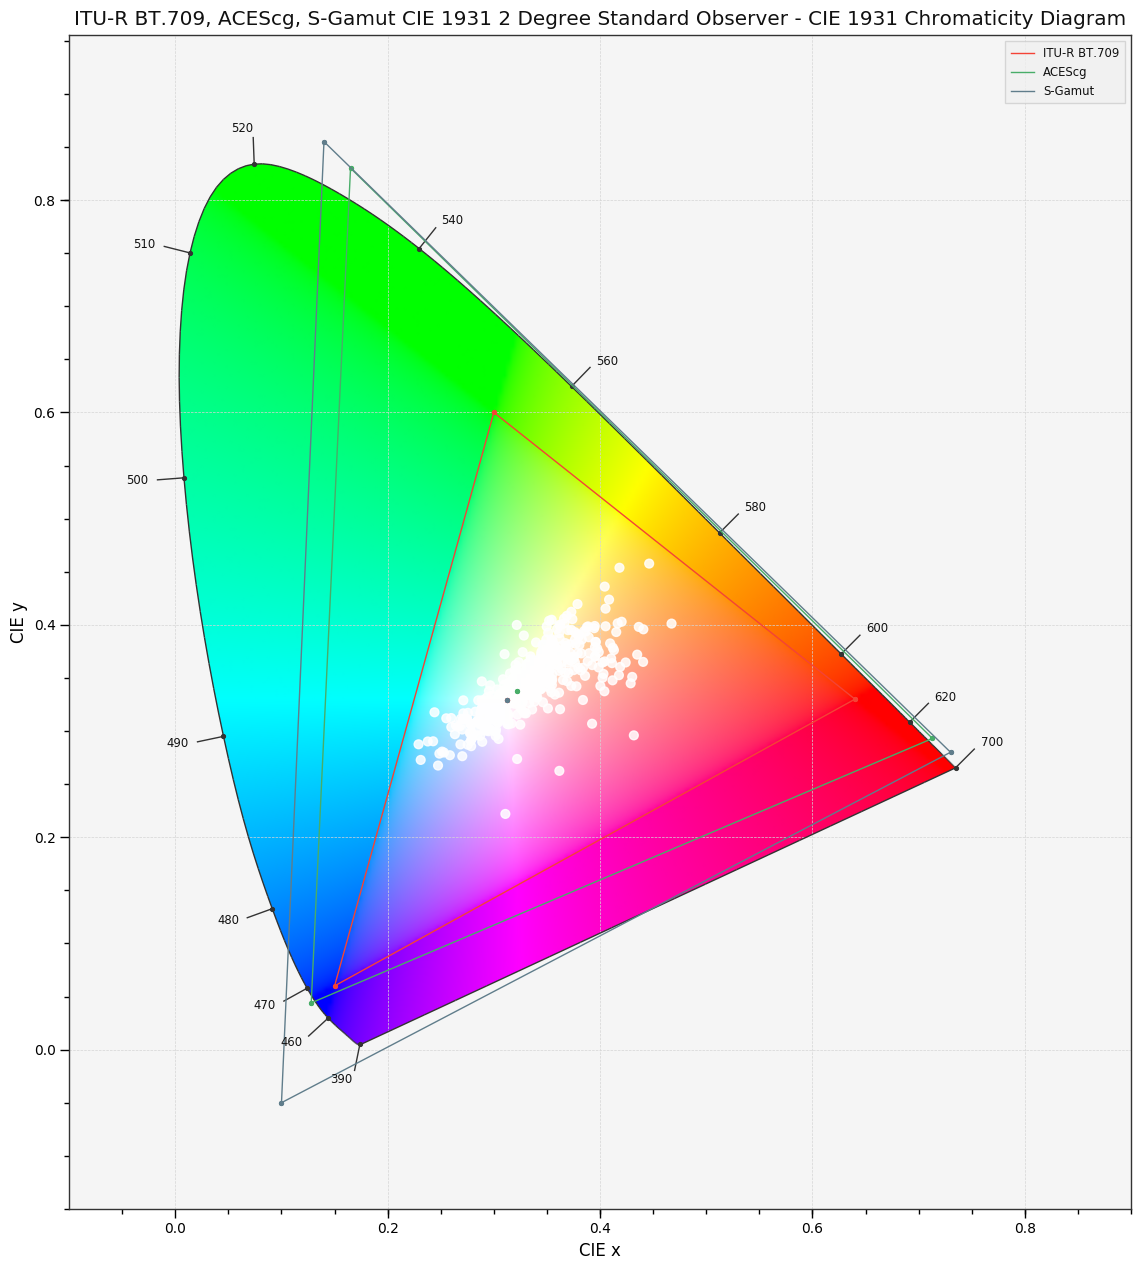

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bb83bb68d0>)

In [11]:
# And plot them in the same way
RGB = np.array(palette)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGB, 'ITU-R BT.709', colourspaces=['ACEScg', 'S-Gamut', 'Pointer Gamut'])